In [ ]:
load up the data

In [1]:
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np

col_names = np.loadtxt('./col_names.txt', dtype='str')
data = pd.read_csv('KDDTest+.csv', header=None, names=col_names)
df = spark.createDataFrame(data)
#should probably normalize here

#one-hot-encode cols 1-3
one_hot_cols = ['protocol_type', 'service', 'flag']
print("column names: ")
print(col_names)

column names: 
['duration' 'protocol_type' 'service' 'flag' 'src_bytes' 'dst_bytes'
 'land' 'wrong_fragment' 'urgent' 'hot' 'num_failed_logins' 'logged_in'
 'num_compromised' 'root_shell' 'su_attempted' 'num_root'
 'num_file_creations' 'num_shells' 'num_access_files' 'num_outbound_cmds'
 'is_host_login' 'is_guest_login' 'count' 'srv_count' 'serror_rate'
 'srv_serror_rate' 'rerror_rate' 'srv_rerror_rate' 'same_srv_rate'
 'diff_srv_rate' 'srv_diff_host_rate' 'dst_host_count'
 'dst_host_srv_count' 'dst_host_same_srv_rate' 'dst_host_diff_srv_rate'
 'dst_host_same_src_port_rate' 'dst_host_srv_diff_host_rate'
 'dst_host_serror_rate' 'dst_host_srv_serror_rate' 'dst_host_rerror_rate'
 'dst_host_srv_rerror_rate' 'label' 'index_label']


In [2]:
#we need the one-hot encode the three columns
from pyspark.ml.feature import OneHotEncoder, StringIndexer
df_one_hot = df
for label in one_hot_cols:
    stringIndexer = StringIndexer(inputCol=label, outputCol=label+"_index")
    model = stringIndexer.fit(df_one_hot)
    indexed = model.transform(df_one_hot)

    encoder = OneHotEncoder(inputCol=label+"_index", outputCol=label+"_vec")
    encoded = encoder.transform(indexed)
    df_one_hot = encoder.transform(indexed).drop(label+"_index").drop(label)


In [3]:
#convert the dataframe into a single column of a vector of features
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

df_non_null = df_one_hot.fillna(0)

feature_labels = ['label', 'index_label']
feature_names = [x for x in df_one_hot.columns if x not in feature_labels]
print(len(feature_names))

vecAssembler = VectorAssembler(inputCols=feature_names, outputCol="features")
vector_features = vecAssembler.transform(df_non_null).drop(*feature_names)

41


In [2]:
look at pca graph

In [ ]:
run the kmeans algorithm and look at the sum of squared errors

In [4]:
#load data
#df = dataset.load()

seed = 1024
num_clusters = vector_features.select('index_label').distinct().count() #22
num_steps = 21
batch_size = 1024
num_features = 41

kmeans = KMeans().setK(num_clusters).setSeed(seed)
kmeansmodel = kmeans.fit(vector_features)

sse = kmeansmodel.computeCost(vector_features)
print("Sum of Squared Errors = " + str(sse))

centers = kmeansmodel.clusterCenters()
print ("Cluster Centers: ")
for center in centers:
    print(center)
    
predictions_df = kmeansmodel.transform(vector_features)


Sum of Squared Errors = 542853923909.0288
Cluster Centers: 
[1.98623681e+02 2.70150765e+02 9.48134895e+02 3.32604771e-04
 9.02784377e-03 2.85089803e-04 7.53587380e-02 2.30922741e-02
 4.16468688e-01 5.03658652e-03 1.71053882e-03 4.75149672e-05
 4.75149672e-03 8.07754443e-03 8.55269410e-04 3.04095790e-03
 0.00000000e+00 5.22664639e-04 3.04570940e-02 8.37496436e+01
 3.23129811e+01 1.09215053e-01 1.09988596e-01 2.32434667e-01
 2.29133327e-01 7.21985650e-01 1.00588235e-01 1.00472774e-01
 1.94873658e+02 1.36539913e+02 5.87001330e-01 9.54818018e-02
 1.30241851e-01 1.89489689e-02 1.04279198e-01 1.05815357e-01
 2.41710064e-01 2.34547182e-01 8.27093034e-01 1.24489214e-01
 3.18017676e-01 2.26788939e-01 7.56438278e-02 4.84177516e-02
 4.39038297e-02 4.24783807e-02 2.83189205e-02 3.98175425e-02
 3.51135608e-02 3.28803573e-02 1.45395800e-02 1.19262568e-02
 7.55487979e-03 6.46203554e-03 3.18350280e-03 2.42326333e-03
 2.37574836e-03 2.28071843e-03 2.18568849e-03 2.18568849e-03
 2.13817352e-03 2.0431435

 0.00000000e+00 5.54016620e-03 2.77008310e-03 0.00000000e+00]
[2.43333333e+01 1.60768111e+05 2.68577778e+03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.77777778e+00
 5.77777778e+00 5.55555556e-02 5.55555556e-02 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.41555556e+02 4.86666667e+01 3.61111111e-01 1.04444444e-01
 3.61111111e-01 2.33333333e-02 1.44444444e-02 1.44444444e-02
 7.44444444e-02 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.88888889e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000

In [ ]:
plot the resulting predictions against the original labels

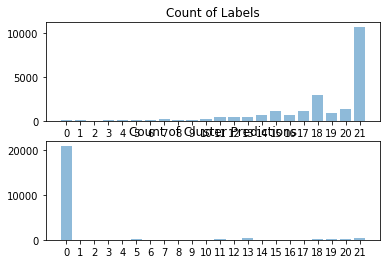

In [23]:
import numpy as np
import matplotlib.pyplot as plt

label_agg_pd = predictions_df.groupBy('index_label').count().sort("index_label").toPandas()
prediction_agg_pd = predictions_df.groupBy('prediction').count().sort("prediction").toPandas()
y_pos = np.arange(len(label_agg_pd['index_label']))

plt.subplot(2,1,1)
plt.bar(y_pos, label_agg_pd['count'], align='center', alpha=0.5)
plt.xticks(y_pos, label_agg_pd['index_label'])
plt.title('Count of Labels')

plt.subplot(2,1,2)
plt.bar(y_pos, prediction_agg_pd['count'], align='center', alpha=0.5)
plt.xticks(y_pos, prediction_agg_pd['prediction'])
plt.title('Count of Cluster Predictions')
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

arrs = []
color_array = []
width = 0.35

label_prediction_agg = predictions_df.groupBy("index_label", "prediction").count()
#label_prediction_agg_pd = label_prediction_agg.toPandas()

ind = np.arange(num_clusters)

for x in ind:
    local_df = label_prediction_agg.filter(col('index_label')==int(x)).toPandas()
    z = np.zeros(num_clusters)
    lst1 = local_df['prediction']
    lst2 = local_df['count']
    np.put(z, lst1, lst2)
    arrs.append(z)


No handles with labels found to put in legend.


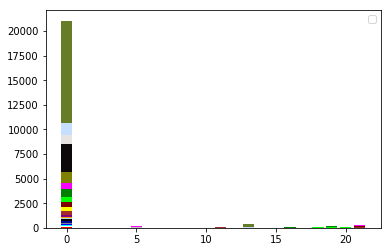

In [15]:
color_list = ["#FF0000", "#FFFFFF", "#00FFFF", "#C0C0C0", "#0000FF", "#808080", "#0000A0", "#000000", "#ADD8E6", "#FFA500", "#800080", "#A52A2A", "#FFFF00", "#800000", "#00FF00", "#008000", "#FF00FF", "#808000", "#0C090A", "#E5E4E2", "#C6DEFF", "#667C26"]
running_total = np.zeros(num_clusters)
for i in range(num_clusters):
    plt.bar(ind, arrs[i], bottom=running_total, color = color_list[i])#, width)
    running_total = running_total + arrs[i]
    
plt.legend()

disproportionate amount of label 21 (and somewhat 18) probably leading to too heavy of a cluster of 0

By examining the results, we see that
From here we can go two directions. Either change the number of clusters, or modify the features (maybe by removing some)

In [15]:
#run pca
from pyspark.ml.feature import PCA
#from pyspark.ml.linalg import Vectors

#convert df to feature_vec
feature_vec = vector_features.select('features')
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(feature_vec)

result = model.transform(feature_vec).select("pcaFeatures")
result.show(truncate=False)

+----------------------------------------------------------------+
|pcaFeatures                                                     |
+----------------------------------------------------------------+
|[0.0012985448463568269,-0.13714055171609763,-0.737627516843336] |
|[9.430635092006036E-4,-0.1070679767438634,0.025903343172861984] |
|[-12982.961704953708,-31.31976012778891,2.685524587886623]      |
|[-19.99966714853025,-0.04455685465930277,-0.14876802923295843]  |
|[-0.03583146565724857,15.014347692458914,1.0665227237130634]    |
|[-302.0079786270363,14514.123712424593,-75.65417504733267]      |
|[-1022.9298853037438,384.471589433497,-0.91898895651706]        |
|[-129.4179691015086,173.67564945210353,0.3356384780235753]      |
|[-328.12413819411836,466.20284465529215,-2.049020530575696]     |
|[-26.378416122358548,156.9268896140636,-0.5951339309005148]     |
|[9.131828980409451E-4,-0.036196518690101535,1.1778723107488458] |
|[-616.7932445742165,328.47254725973596,-0.5594421705380771]  

In [19]:
reslist = [x['pcaFeatures'] for x in result.collect()]
reslist

[DenseVector([0.0013, -0.1371, -0.7376]),
 DenseVector([0.0009, -0.1071, 0.0259]),
 DenseVector([-12982.9617, -31.3198, 2.6855]),
 DenseVector([-19.9997, -0.0446, -0.1488]),
 DenseVector([-0.0358, 15.0143, 1.0665]),
 DenseVector([-302.008, 14514.1237, -75.6542]),
 DenseVector([-1022.9299, 384.4716, -0.919]),
 DenseVector([-129.418, 173.6756, 0.3356]),
 DenseVector([-328.1241, 466.2028, -2.049]),
 DenseVector([-26.3784, 156.9269, -0.5951]),
 DenseVector([0.0009, -0.0362, 1.1779]),
 DenseVector([-616.7932, 328.4725, -0.5594]),
 DenseVector([0.0009, -0.0986, 0.2233]),
 DenseVector([0.0016, -0.0748, -0.1775]),
 DenseVector([-1651.4417, 364192.1888, -1880.7021]),
 DenseVector([-358.7052, 3609.1262, -18.638]),
 DenseVector([-214.5874, 658.4548, -2.468]),
 DenseVector([-251.0393, 2089.4079, -10.8783]),
 DenseVector([-45.1024, 43.6592, -4.4558]),
 DenseVector([0.0012, -0.128, -0.5563]),
 DenseVector([0.001, -0.0993, 0.1283]),
 DenseVector([0.0008, -0.0446, 1.1541]),
 DenseVector([-200.3951, 18

In [16]:
result

DataFrame[pcaFeatures: vector]

No handles with labels found to put in legend.


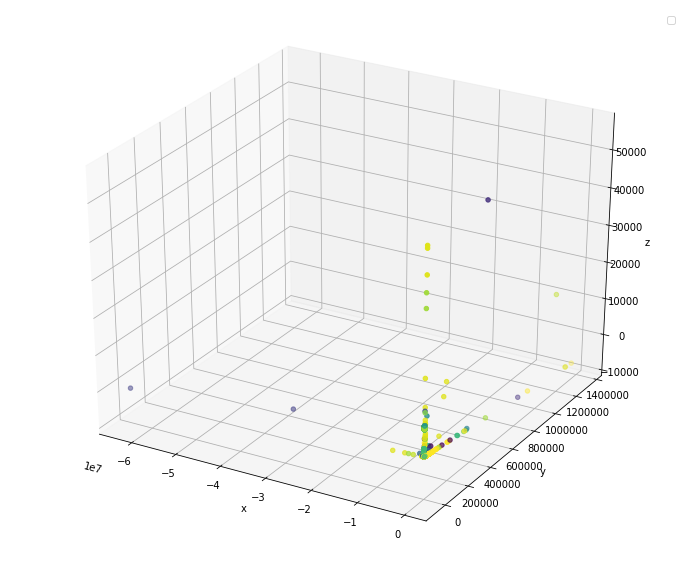

In [22]:
#plot the pca features
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

y_num_label = data['index_label']

#resultfeats[0], resultfeats[1], resultfeats[2]
xnums = [reslist[x][0] for x in range(0,len(reslist))]
ynums = [reslist[y][1] for y in range(0,len(reslist))]
znums = [reslist[z][2] for z in range(0,len(reslist))]

#resultfeats = result.show(truncate=False)
mplt = plt.figure(figsize=(12,10)).gca(projection='3d')
mplt.scatter(xnums, ynums, znums, c=y_num_label)
mplt.set_xlabel('x')
mplt.set_ylabel('y')
mplt.set_zlabel('z')
plt.legend()
plt.show()

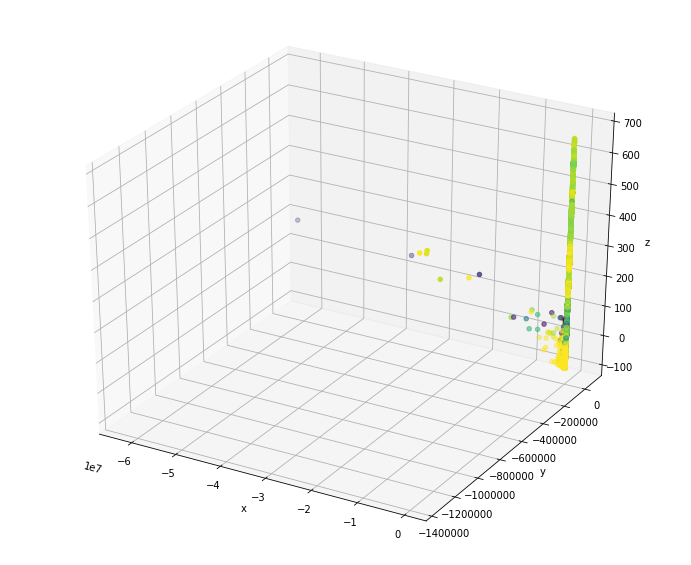

In [67]:
#plot the pca features
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

y_num_label = data[42]

#resultfeats[0], resultfeats[1], resultfeats[2]
xnums = [reslist[x][0] for x in range(0,len(reslist))]
ynums = [reslist[y][1] for y in range(0,len(reslist))]
znums = [reslist[z][2] for z in range(0,len(reslist))]

#resultfeats = result.show(truncate=False)
mplt = plt.figure(figsize=(12,10)).gca(projection='3d')
mplt.scatter(xnums, ynums, znums, c=y_num_label)
mplt.set_xlabel('x')
mplt.set_ylabel('y')
mplt.set_zlabel('z')
#plt.legend()?
plt.show()

#need to add legend